# Data Mining

## Lab 2: Naive Bayes dan Decision Trees

Anda akan mengenal dua jenis distribusi yang digunakan dalam algoritma Naive Bayes: Gaussian dan Bernoulli. Untuk memberikan gambaran lebih jauh, dalam praktikum ini Anda juga akan melihat bagaimana menggambarkan kurva distribusi bivariate Gaussian, i.e. Gaussian dengan dua variabel. Selain itu, Anda juga akan mengeksplorasi bagaimana mencocokkan nilai Maximum Likelihood Estimation (MLE) dari kedua distribusi tersebut, lalu menggunakan asumsi *conditional independence* untuk membentuk algoritma Naive Bayes.

Sebelum masuk ke dalam algortima decision trees, Anda akan mempelajari bagaimana melakukan transformasi data dengan *one-hot-encoding* atau *one-of-K encoding* sehingga dapat digunakan untuk berbagai algoritma *machine learning*. Untuk memastikan bahwa algoritma *machine learning* yang Anda gunakan memberikan kinerja yang optimal, Anda juga akan belajar untuk melakukan *hyperparameter tuning*. Terakhir, Anda juga diminta membuat kurva ROC sebagai alternatif dari pengukuran kinerja model yang dibentuk dengan *machine learning*.

## Daftar isi

- [Gaussian Naive Bayes](#Gaussian-Naive-Bayes)
- [Bernoulli Naive Bayes](#Bernoulli-Naive-Bayes)
- [Decision Trees](#Decision-Trees)

In [1]:
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
%matplotlib inline

plt.style.use('ggplot')
warnings.filterwarnings("ignore")

RANDOM_STATE = 91

# Gaussian Naive Bayes

In [2]:
df = sns.load_dataset('iris')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
df.species.value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

### Fitting Gaussian MLE

In [4]:
# Membuang elemen yang tidak kita gunakan
del df['sepal_length']
del df['sepal_width']
# Menghitung nilai MLE mean dan std untuk distribusi Gaussian petal_length dan petal_width
df.groupby('species').aggregate(['mean', 'std', 'min', 'max'])

petal_length                     petal_width                    
                   mean       std  min  max        mean       std  min  max
species                                                                    
setosa            1.462  0.173664  1.0  1.9       0.246  0.105386  0.1  0.6
versicolor        4.260  0.469911  3.0  5.1       1.326  0.197753  1.0  1.8
virginica         5.552  0.551895  4.5  6.9       2.026  0.274650  1.4  2.5

Perhitungan rata-rata dan variansi dari r.v. `petal_length` dan `petal_width` untuk distribusi Gaussian dapat dilakukan dengan:
$$
\hat{\mu}_{l,setosa} = \frac{1}{50} \sum_{i;y=setosa} l_i
$$
$$
\hat{\sigma}_{l,setosa}^2 = \frac{1}{50} \sum_{i;y=setosa} (l_i - \hat{\mu}_{l,setosa})^2
$$
$$
\hat{\mu}_{w,setosa} = \frac{1}{50} \sum_{i;y=setosa} w_i
$$
$$
\hat{\sigma}_{w,setosa}^2 = \frac{1}{50} \sum_{i;y=setosa} (w_i - \hat{\mu}_{w,setosa})^2
$$

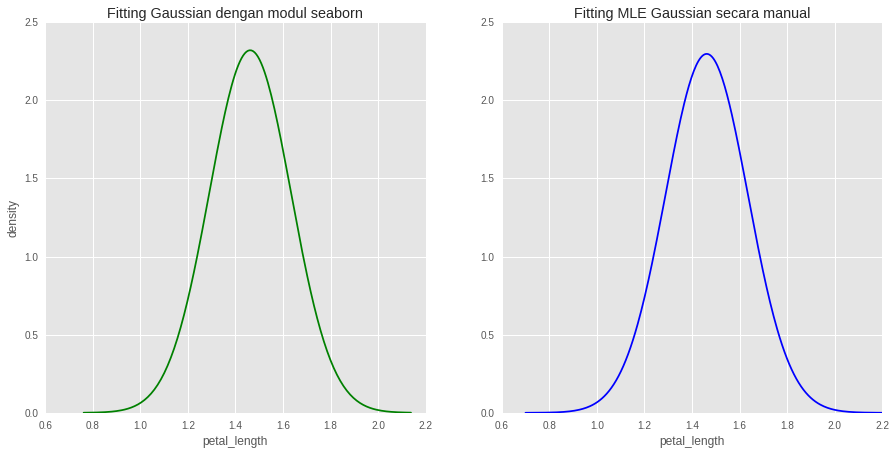

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.distplot(df[df.species == 'setosa'].petal_length, kde=False, fit=norm, hist=False, fit_kws={'color': 'g'}, ax=ax[0])
ax[0].set_ylabel('density')
ax[0].set_title('Fitting Gaussian dengan modul seaborn')

ax[1].set_title('Fitting MLE Gaussian secara manual')
x = np.linspace(0.7, 2.2, 300) # membuat nilai dari [0.7, 2.2] yang dibagi menjadi 300 titik
mu_setosa = df[df.species == 'setosa'].petal_length.mean()
std_setosa = df[df.species == 'setosa'].petal_length.std()
ax[1].plot(x, norm.pdf(x, mu_setosa, std_setosa), color='b')
ax[1].set_xlabel('petal_length')
plt.show()

![Gaussian MLE](http://uai.aliakbars.com/images/mle.gif)

In [6]:
s = df[df.species == 'setosa']
ve = df[df.species == 'versicolor']
vi = df[df.species == 'virginica']

### 3D Plot untuk Setosa (Bivariate Gaussian)

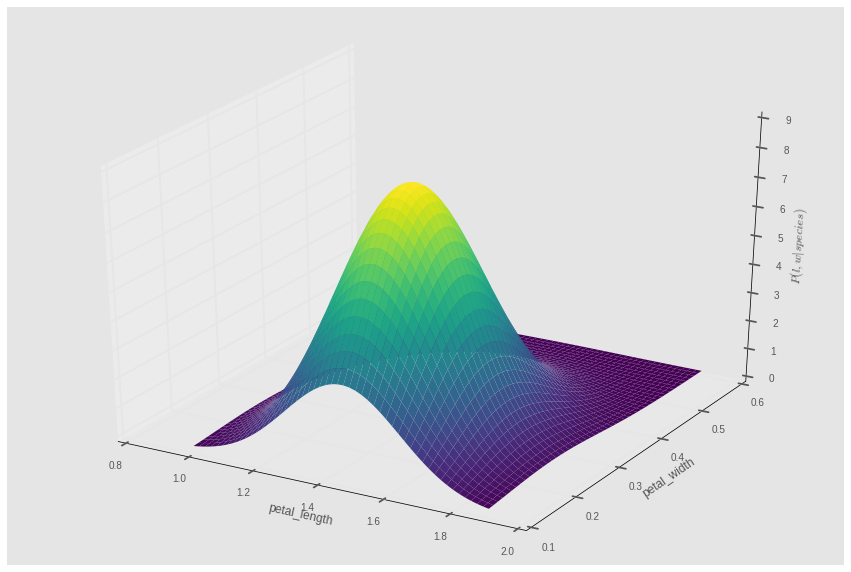

In [7]:
pl = np.linspace(s.petal_length.min(), s.petal_length.max(), 500)
pw = np.linspace(s.petal_width.min(), s.petal_width.max(), 500)
x1, x2 = np.meshgrid(pl, pw)
z = bivariate_normal(x1, x2, s.petal_length.std(), s.petal_width.std(), s.petal_length.mean(), s.petal_width.mean())

fig = plt.figure()
fig.set_size_inches(15,10)
ax = fig.gca(projection='3d')
ax.plot_surface(x1, x2, z, cmap='viridis', linewidth=0)
ax.set_xlabel('petal_length')
ax.set_ylabel('petal_width')
ax.set_zlabel('$P(l,w|species)$')
plt.show()

Bivariate Gaussian spesies Setosa yang dibentuk dalam 3D. Grafik setelah ini menunjukkan pemetaannya dalam dua dimensi.

### Contour Plot (Top View)

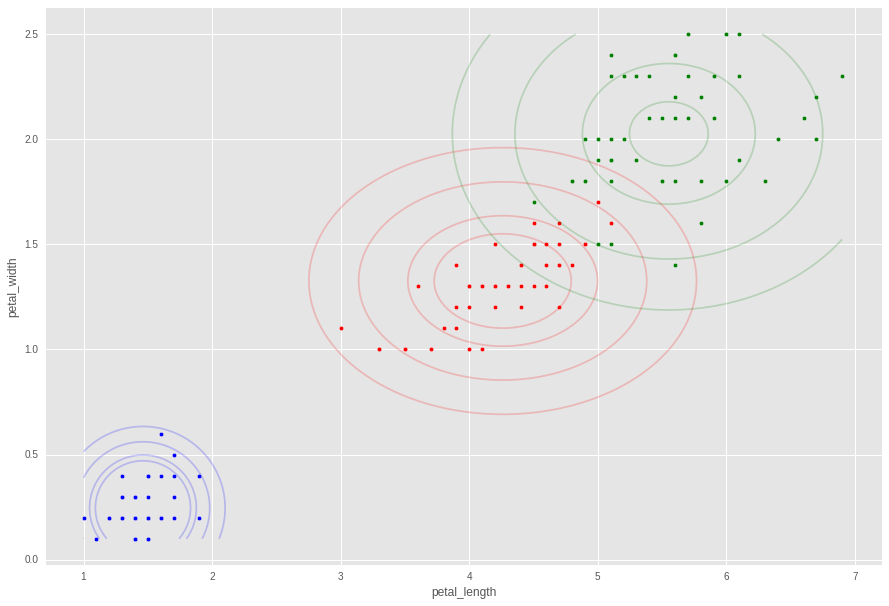

In [8]:
fig, ax = plt.subplots(figsize=(15,10))
pl = np.linspace(df.petal_length.min(), df.petal_length.max(), 500)
pw = np.linspace(df.petal_width.min(), df.petal_width.max(), 500)

cmaps = ['Blues', 'Reds', 'Greens']
for species, c in zip([s, ve, vi], cmaps):
    x1, x2 = np.meshgrid(pl, pw)
    z = bivariate_normal(x1, x2, species.petal_length.std(), species.petal_width.std(), species.petal_length.mean(), species.petal_width.mean())
#     cf = ax.contourf(x1, x2, z, cmap=c, alpha=0.5)
    color = c[0].lower()
    ax.scatter(species.petal_length, species.petal_width, c=color)
    ax.contour(x1, x2, z,
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)

ax.set_xlabel('petal_length')
ax.set_ylabel('petal_width')
plt.show()

Dapat dilihat di grafik di atas bahwa setiap bivariate Gaussian yang dihasilkan memiliki garis pemisah satu sama lainnya (tidak tergambar). Tiap warna dari grafik di atas mewakili satu spesies Iris. Apa asumsi Anda terhadap kinerja klasifikasi dengan algoritma Gaussian Naive Bayes nanti?

### Pembagian Data

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df = sns.load_dataset('iris')
X = df.drop([df.columns[-1]], axis=1)
y = le.fit_transform(df.species) # mengubah spesies menjadi nilai numerik
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

### Klasifikasi

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB() # inisialisasi classifier
clf.fit(X_train, y_train) # membuat model dengan melakukan fitting class-conditional Gaussians
y_pred = clf.predict(X_test) # memprediksi data baru dengan menggunakan model yang telah dibentuk

print "Akurasi: %.4f" % accuracy_score(y_test, y_pred)
print "Confusion matrix"
print confusion_matrix(y_test, y_pred)

Akurasi: 1.0000
Confusion matrix
[[15  0  0]
 [ 0 18  0]
 [ 0  0 17]]


Hasil klasifikasi dengan Gaussian NB menunjukkan bahwa kita bisa mencapai akurasi 100% dengan algoritma sederhana seperti Naive Bayes. Perlu diketahui bahwa kasusnya mungkin tidak akan sebaik ini jika datanya lebih besar dan tidak terlihat _linearly separable_.

# Bernoulli Naive Bayes

Dalam kasus ini, kita akan menggunakan data Titanic. Deskripsi dari dataset ini bisa dilihat di [sini](https://www.kaggle.com/c/titanic/data).

In [11]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


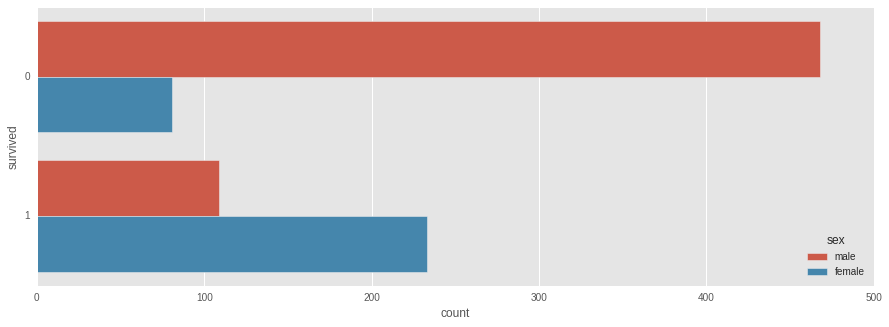

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(y='survived', hue='sex', data=df, ax=ax)
plt.show()

### Fitting Bernoulli MLE

In [13]:
sex = pd.crosstab(df.sex, df.survived, margins=True).apply(lambda x: x/float(x[-1]))
sex

survived,0,1,All
sex,,,
female,0.147541,0.681287,0.352413
male,0.852459,0.318713,0.647587
All,1.000000,1.000000,1.000000


Perhitungan di atas menunjukkan:

$P(male|survived) = 0.318713$

$P(female|survived) = 0.681287$

$P(male|dead) = 0.852459$

$P(female|dead) = 0.147541$

dengan kata lain, kita akan lebih mungkin menemukan wanita dari para penyintas (_survivor_). Dalam Bernoulli NB, kita akan melakukan perhitungan probabilitas seperti ini untuk tiap pasangan atribut dengan kelas (karena asumsi _class-conditional independence_).

In [14]:
alone = pd.crosstab(df.alone, df.survived, margins=True).apply(lambda x: x/float(x[-1]))
print alone
alone[1][False] # cara mengakses: dataframe[kelas][atribut]

survived         0         1       All
alone                                 
False     0.318761  0.523392  0.397306
True      0.681239  0.476608  0.602694
All       1.000000  1.000000  1.000000


0.52339181286549707

Untuk Bernoulli NB dengan dua variabel (`sex` dan `alone` saja), maka probabilitasnya menjadi:

$$
P(survived|sex,alone) = \frac{P(sex,alone|survived)P(survived)}{P(sex,alone)}
$$
$$
P(survived|sex,alone) = \frac{P(sex|survived)P(alone|survived)P(survived)}{\sum_{survived \in \{0,1\}} P(sex|survived)P(alone|survived)P(survived)}
$$

### Prapemrosesan Data

Dalam kasus ini, kita hanya akan menggunakan tiga fitur, yaitu jenis kelamin, pergi sendiri atau tidak, dan kota keberangkatan. Transformasi data yang perlu digarisbawahi di sini adalah tentang [one-hot-encoding](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science/answer/H%C3%A5kon-Hapnes-Strand).

In [15]:
from sklearn.preprocessing import LabelEncoder

X = df[~df.embarked.isnull()][['sex', 'alone', 'embarked']]
print X.head()
le = LabelEncoder()
X['sex'] = le.fit_transform(X['sex']) # mengubah string dan boolean menjadi numerik
X['alone'] = le.fit_transform(X['alone'])
print X.head()
X = pd.concat([X, pd.get_dummies(X.embarked)], axis=1) # mengubah nilai nominal dengan one-hot-encoding
print X.head()

X = X[['sex','alone','C','Q','S']]
y = df[~df.embarked.isnull()].survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

      sex  alone embarked
0    male  False        S
1  female  False        C
2  female   True        S
3  female  False        S
4    male   True        S
   sex  alone embarked
0    1      0        S
1    0      0        C
2    0      1        S
3    0      0        S
4    1      1        S
   sex  alone embarked    C    Q    S
0    1      0        S  0.0  0.0  1.0
1    0      0        C  1.0  0.0  0.0
2    0      1        S  0.0  0.0  1.0
3    0      0        S  0.0  0.0  1.0
4    1      1        S  0.0  0.0  1.0


### Klasifikasi

In [16]:
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB() # inisialisasi classifier
clf.fit(X_train, y_train) # membuat model dengan melakukan fitting class-conditional Gaussians
y_pred = clf.predict(X_test) # memprediksi data baru dengan menggunakan model yang telah dibentuk

print "Akurasi: %.4f" % accuracy_score(y_test, y_pred)
print "Confusion matrix"
print confusion_matrix(y_test, y_pred)

Akurasi: 0.7789
Confusion matrix
[[160  35]
 [ 30  69]]


# Decision Trees

Dalam pustaka scikit-learn yang digunakan dalam modul praktikum ini, implementasi dari decision trees yang diberikan hanya satu jenis. Jenis pohon yang digunakan adalah CART yang teroptimasi. Silakan lihat dokumentasinya di [sini](http://scikit-learn.org/stable/modules/tree.html). Berbeda dengan Naive Bayes, ada lebih banyak _hyperparameters_ yang harus disesuaikan dalam algoritma Decision Trees.

In [17]:
X = df[['pclass', 'sex', 'age', 'fare', 'embarked', 'alone']]
X[X.isnull().any(axis=1)]

,pclass,sex,age,fare,embarked,alone
5,3,male,NaN,8.4583,Q,True
17,2,male,NaN,13.0000,S,True
19,3,female,NaN,7.2250,C,True
26,3,male,NaN,7.2250,C,True
28,3,female,NaN,7.8792,Q,True
29,3,male,NaN,7.8958,S,True
31,1,female,NaN,146.5208,C,False
32,3,female,NaN,7.7500,Q,True
36,3,male,NaN,7.2292,C,True
42,3,male,NaN,7.8958,C,True


Perhatikan bahwa ada banyak nilai `age` yang kosong. Untuk itu, kita perlu mengganti nilai tersebut (_impute_). Salah satu opsi nilai pengganti adalah dengan median atau mean.

In [18]:
X.age.median()

28.0

In [19]:
X['age'] = X.age.fillna(X.age.median())

In [20]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

y = df['survived']

X['sex'] = le.fit_transform(X['sex'])
X['alone'] = le.fit_transform(X['alone'])
X = pd.concat([X, pd.get_dummies(X.embarked)], axis=1)
del X['embarked']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RANDOM_STATE)

### Hyperparameter Tuning

In [21]:
from sklearn.tree import DecisionTreeClassifier

# Kode diadaptasi dari http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

clf = DecisionTreeClassifier()

parameter_grid = {
                 'max_depth' : [4,5,6,7,8],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(y_train, n_folds=10) # Stratified 10-fold cross-validation

grid_search = GridSearchCV(clf,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train, y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.818791946309
Best parameters: {'criterion': 'entropy', 'max_depth': 4}


### Klasifikasi

In [22]:
y_pred = grid_search.predict(X_test)

print "Akurasi: %.4f" % accuracy_score(y_test, y_pred)
print "Confusion matrix"
print confusion_matrix(y_test, y_pred)

Akurasi: 0.8102
Confusion matrix
[[162  29]
 [ 27  77]]


### ROC Curve

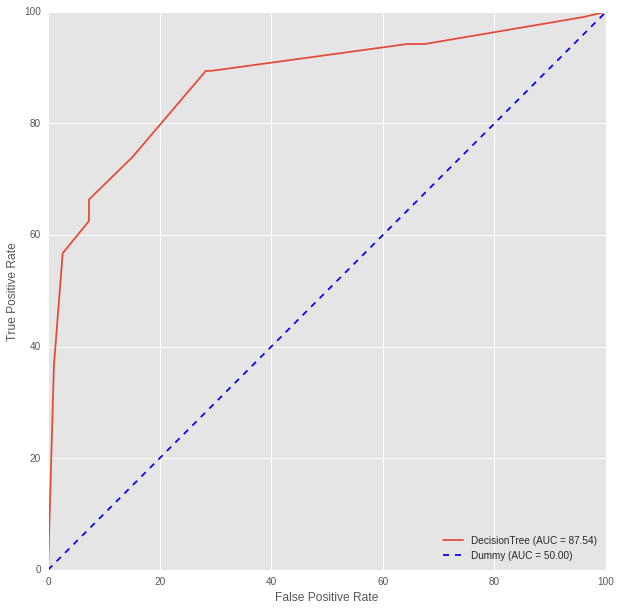

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

score = grid_search.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, score[:,1])
auc = roc_auc_score(y_test, score[:,1])

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(fpr*100, tpr*100, label='%s (AUC = %.2f)' % ('DecisionTree', auc*100))
ax.plot([0,100], [0,100], label='Dummy (AUC = 50.00)', linestyle='--', color='b')
ax.legend(loc=4)
plt.show()

_Dummy classifier_ dalam kasus ini dihasilkan dengan memprediksi data uji berdasarkan probabilitas kelas _prior_ dari data latih.